<a href="https://www.kaggle.com/code/kaushiksuresh147/bitcoin-volatility-analysis-with-interactive-viz?scriptVersionId=103971474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="text-align:center"><img src="https://i.pinimg.com/originals/0f/f7/78/0ff7784184af761d38db3013a4d1584e.gif" width="1000"></div>

<div class='alert alert-info' style="color:white;
           display:fill;
           border-radius:6px;
           background-color:#5642C5;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.8px;
           text-align:center;">
    <h3><center>Bitcoin (₿)</center></h3>
<h4>Bitcoin is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries.Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. The cryptocurrency was invented in 2008 by an unknown person or group of people using the name Satoshi Nakamoto. The currency began use in 2009 when its implementation was released as open-source software.</h4>
<br>
<h4>Bitcoins are created as a reward for a process known as mining. They can be exchanged for other currencies, products, and services. Bitcoin has been criticized for its use in illegal transactions, the large amount of electricity (and thus carbon footprint) used by mining, price volatility, and thefts from exchanges. Some investors and economists have characterized it as a speculative bubble at various times. Others have used it as an investment, although several regulatory agencies have issued investor alerts about bitcoin. In September 2021, El Salvador officially adopted Bitcoin as legal tender, becoming the first and only nation in the world to do so.</h4>
</div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
            text-align:center">
        <p style="padding: 10px;
              color:white;">
            <center>Required Libraries<center>
        </p>
</div>

In [1]:
import pandas as pd

import pandas as pd
import numpy as np 
import missingno as mno
import pickle 
import json
import time 
import gc
import random
import sklearn

#For Data Visualization
import matplotlib.pyplot as plt
#%matplotlib inline 
#output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

#NetworkX
import networkx as nx
import plotly.express as px 
import plotly.graph_objects as go #To construct network graphs
from plotly.subplots import make_subplots #To make multiple plots

#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import init_notebook_mode, iplot
from IPython.core.display import display, HTML #To display html content in a code cell
init_notebook_mode(connected=True)

gc.collect()



30

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
            text-align:center">
        <p style="padding: 10px;
              color:white;">
            <center>Data Cleaning<center>
        </p>
</div>

In [2]:

raw_data=pd.read_csv('../input/top-10-cryptocurrencies-historical-dataset/Top 100 Crypto Coins/bitcoin.csv')
def date_format(df):
    if isinstance(df, pd.DataFrame):
        if 'Date' in df.columns:
            df.Date = pd.to_datetime(df.Date)
            df[['Year','Month','Day']] = df.Date.apply(lambda x: pd.Series(x.strftime("%Y-%m-%d").split("-")))
    else:
        print("Invalid entry, please use a data frame with a Date column.")
    return df

data=date_format(raw_data)
data['Close']=data['Close'].astype(float)
data['Open']=data['Open'].astype(float)
data['High']=data['High'].astype(float)
data['Low']=data['Low'].astype(float)
data['Year']=data['Year'].astype(int)
data['Month']=data['Month'].astype(int)
data['Day']=data['Day'].astype(int)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
            text-align:center">
        <p style="padding: 10px;
              color:white;">
            <center>Data Summary <center>
        </p>
</div>

In [3]:
#Seaborn plot viz of the missing values in the data 
def missing_values(data):
    #import seaborn as sns
    missed = pd.DataFrame()
    missed['column'] = data.columns

    missed['percent'] = [round(100* data[col].isnull().sum() / len(data), 2) for col in data.columns]
    missed = missed.sort_values('percent',ascending=False)
    missed = missed[missed['percent']>0]

    fig = sns.barplot(
        x=missed['percent'], 
        y=missed["column"], 
        orientation='horizontal',palette="winter"
    ).set_title('Missed values percent for every column')


def triple_plot(x, title,c): # Use triple plot for numeric and important key features 
    fig, ax = plt.subplots(3,1,figsize=(20,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    #fig.suptitle(title, fontsize=30)
    #plt.tight_layout(pad=3.0)
    plt.show()

#Info, missing values and describe of the dataframe along with the triple plot of integer variables
def data_understand(df):
    display(HTML('<div class="alert alert-info"><h4><center>Data Information</center></h4></div><br>'))
    print(df.info())
    display(HTML('<br><div class="alert alert-info"><h4><center>Data Description</center></h4></div><br>'))
    req_cols=df.select_dtypes(include=np.number).columns.to_list()[0:6]
    print(pd.DataFrame(round(df[req_cols].describe(),2)))
    try: missing_values(df)
    except: pass;
    display(HTML('<br><div class="alert alert-info"><h4><center>Missing values</center></h4></div><br>'))
    #print('\n\nNA Values statistics')
    print(df.isna().sum())
    print('\nNo missing values were present! 💯')
    print('\n\n')
    #df.hist(bins=10,figsize=(20,15)) 
    #For smaller data use smaller bin sizes(5 to 20), increase accordingly if the data size increases
    plt.show()
    clrs=0
    display(HTML('<br><div class="alert alert-info"><h4><center>Distribution of OHLC Values of Bitcoin</center></h4></div><br>'))
    for i in df.select_dtypes(include=np.number).columns.to_list()[0:5]:
        if i!='Volume': display(HTML('<div style="color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:150%;font-family:Verdana;letter-spacing:0.5px;text-align:center"><p style="padding: 10px;color:white;"><center> BTC {} Price<center></p></div>'.format(i)))
        else: display(HTML('<div style="color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:150%;font-family:Verdana;letter-spacing:0.5px;text-align:center"><p style="padding: 10px;color:white;"><center> BTC trading {} <center></p></div>'.format(i)))
        triple_plot(df[i], str(i).upper(),custom_colors[random.choice([0,1,2,3])])
        print('\n')
    display(HTML('<br><div class="alert alert-info"><h4><center>The Distributions of OHLC(Opening, Highest, Lowest, and Closing price) follow a log-normal distribution. Due to the very reason using mean as a central tendency measure wouldnt be ideal in this case. Since the distribution is log-normal, the mean values could be skewed. Therefore, for that very reason, we will be using median values as they are less prone to skewness.</center></h4></div><br>'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4420 non-null   datetime64[ns]
 1   Open      4420 non-null   float64       
 2   High      4420 non-null   float64       
 3   Low       4420 non-null   float64       
 4   Close     4420 non-null   float64       
 5   Volume    4420 non-null   int64         
 6   Currency  4420 non-null   object        
 7   Year      4420 non-null   int64         
 8   Month     4420 non-null   int64         
 9   Day       4420 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 345.4+ KB
None


           Open      High       Low     Close        Volume     Year
count   4420.00   4420.00   4420.00   4420.00  4.420000e+03  4420.00
mean    8302.22   8531.97   8043.47   8306.97  1.395788e+07  2016.09
std    14598.40  14992.61  14146.50  14599.05  1.645973e+08     3.52
min        0.00      0.10      0.00      0.10  0.000000e+00  2010.00
25%      122.50    129.98    118.30    122.80  3.013600e+04  2013.00
50%      683.60    706.50    657.55    685.00  6.762050e+04  2016.00
75%     8877.25   9122.70   8666.90   8886.08  1.769402e+05  2019.00
max    67528.70  68990.60  66334.90  67527.90  4.468697e+09  2022.00


Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
Year        0
Month       0
Day         0
dtype: int64

No missing values were present! 💯





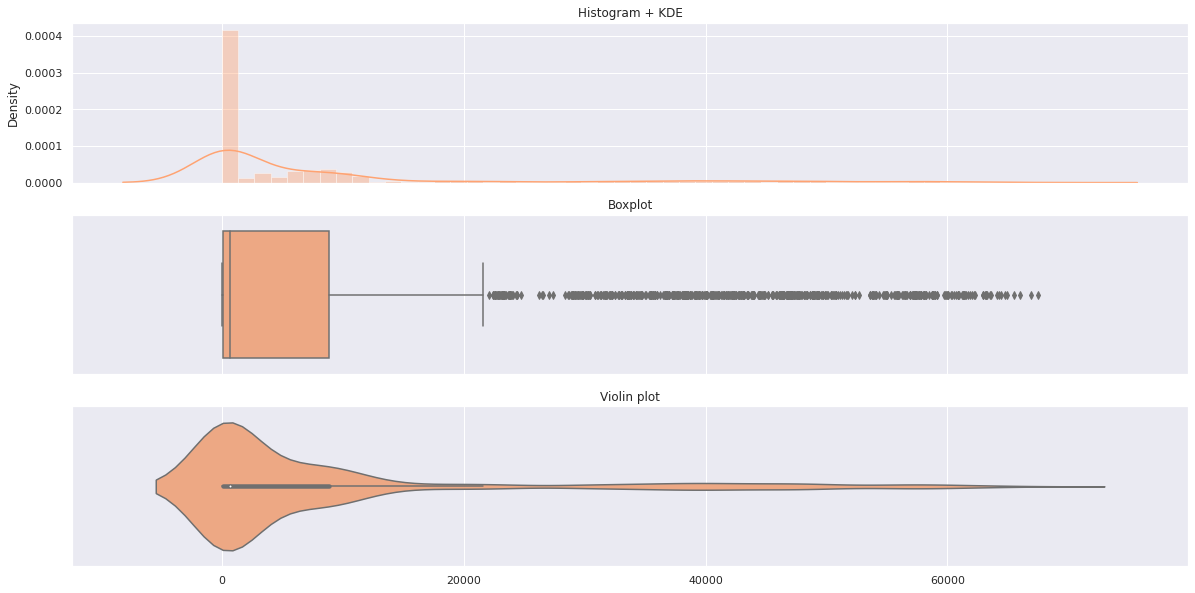

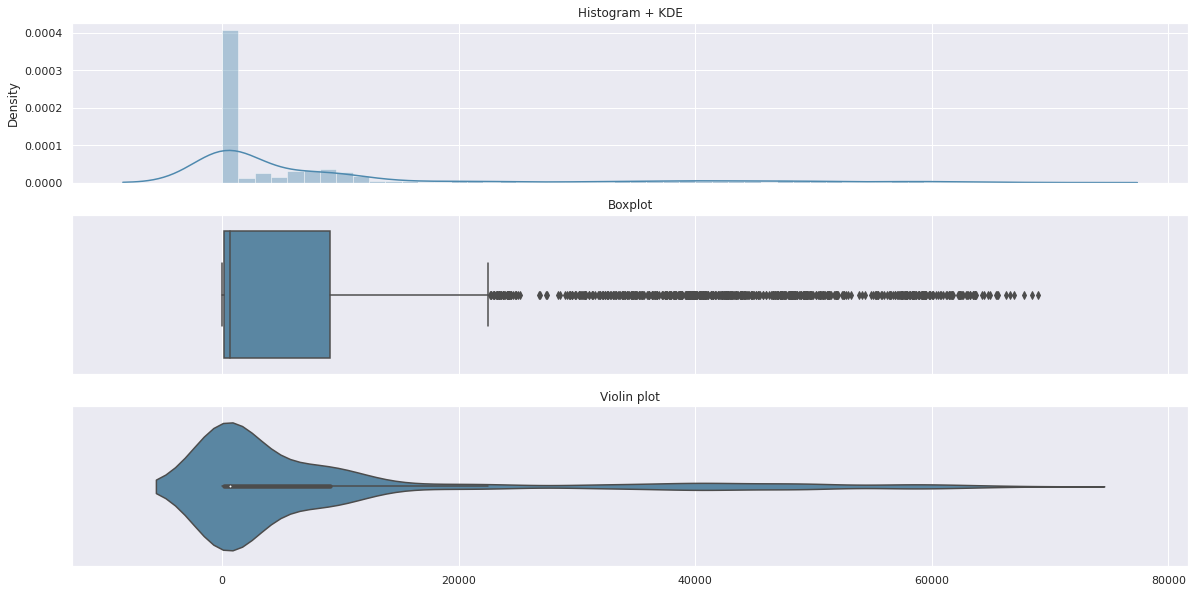

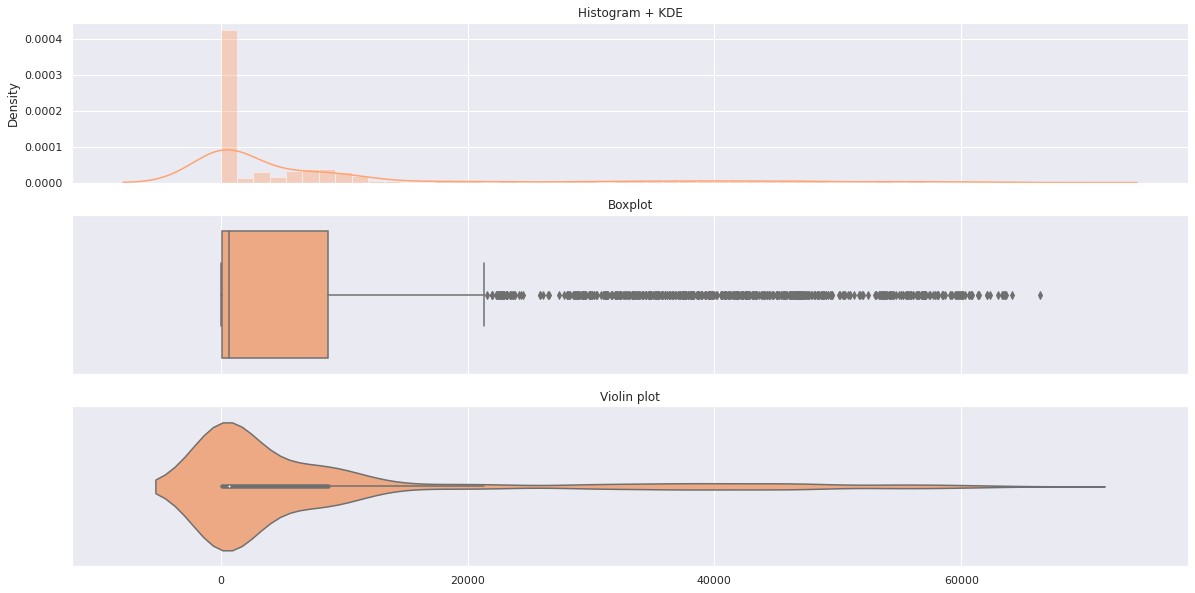

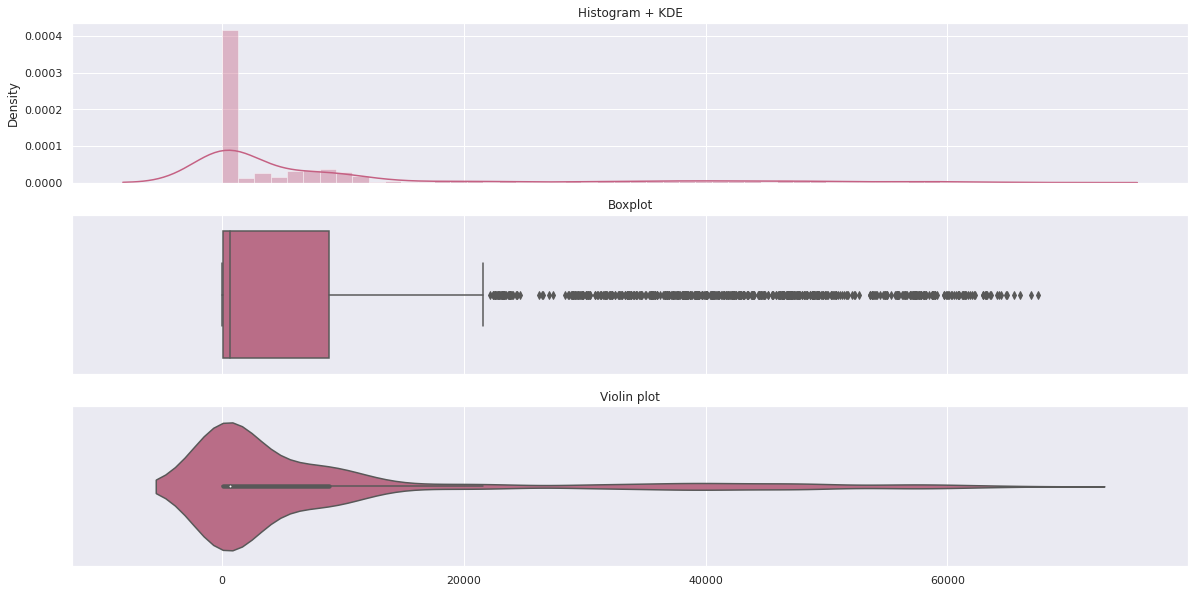

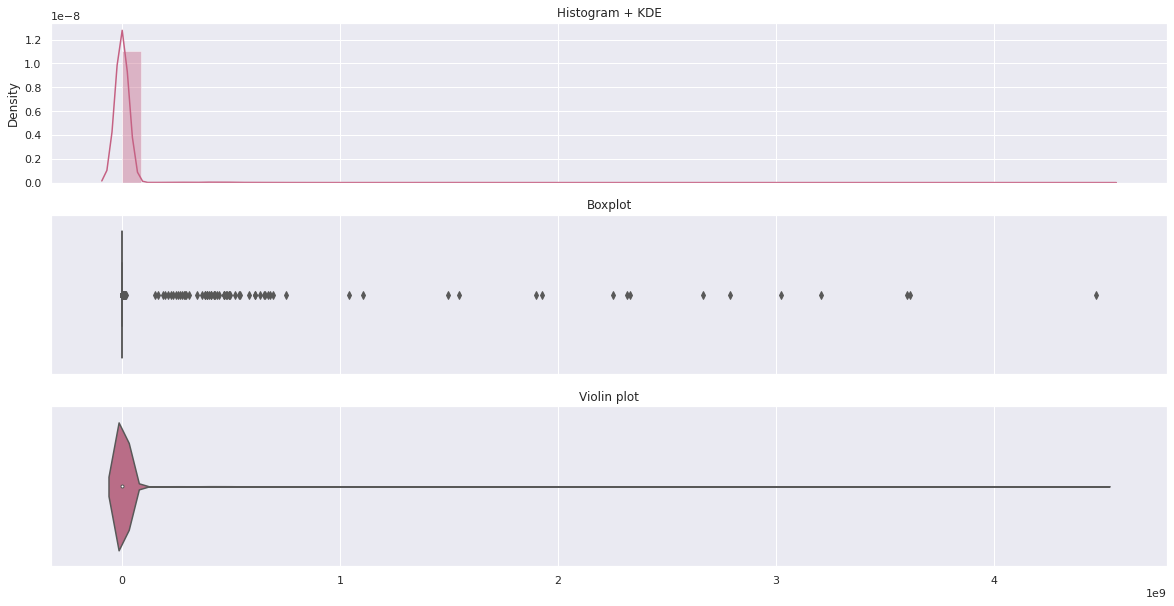

In [4]:
data_understand(data)

In [5]:
fig = px.line(data, x="Year", y="Close", title='BTC price over the years',text='Year')
fig.update_traces(textposition="bottom right")
fig.update_layout(template='plotly_dark',
    yaxis_title='Closing price',
    hovermode="x",title_x=0.5
)
fig.show()

<div class='alert alert-info'>
    <h4><center>Usually in finance world, candle stick charts are the most preffered to visualize the prices of any stock/crypto. But this visualization looks like a building over the years as shown in the below image. Just thinking out loud  😂</center></h4>
</div>

<div style="text-align:center"><img src="https://images.adsttc.com/media/images/5c1a/97d7/08a5/e5c8/b900/054e/newsletter/Chicago_S._extra_asset__outreach_-min.jpg?1545246670" wifth="500"></div>

In [6]:
fig = go.Figure(data=go.Ohlc(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']))
fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(template='plotly_dark',
    title='BTC Price over the years',
    xaxis_title="Year",
    yaxis_title='BTC Price',title_x=0.5)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)
fig.show()

In [7]:

fig = go.Figure(data=go.Ohlc(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']))

fig.update_layout(template='plotly_dark',
    title='BTC Price over the years',
    xaxis_title="Year",
    yaxis_title='BTC Price',title_x=0.5,
    shapes = [dict(x0='2017-09-01', x1='2017-09-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2018-01-10', x1='2018-01-10', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2020-11-01', x1='2020-11-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
             dict(x0='2021-05-01', x1='2021-05-01', y0=0, y1=1, xref='x', yref='paper',line_width=2)],
    annotations=[dict(x='2017-01-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2018-01-10', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻'),
        dict(x='2020-11-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2021-08-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻')]
)

fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=False
)

fig.update_xaxes(
     showgrid=True
)

fig.show()

<div class='alert alert-info'>
<h3> <center>What is a bull🐂' / bear🐻  market?</center></h3>
<h4>Bull market and bear market are said to be two opposite phases in a market.</h4>
<ol>

<li>In a bull market 🐂', cryto/stock prices continue to rise over a period of time(They call it bullish because, when a bull attacks it moves it horns upward😈)
<li>In a bear market 🐻 , prices continue to decline over a period of time( When a bear attacks it waves it claws downward😈, which can be related to the decrease in price)
</ol>
    
<h4>For example, in the above graph you can see that the bull run started around 2017-09-01 and the bear market started around 2018-01-10 ending the bull run. And, similiarly, we can see an another huge bull run, which probably started around 2020-11-01 and ended in 2021-05-01 starting the bear run.</h4>
    
<h4> I would prefer to invest during the bear market, buying the dip and sell during the bull market and lock the profits (P.S : This is not an investment advice 🙅🏻‍♂️)</h4>

              
</div>

In [8]:

year_bin_5=[2009,2011,2014,2018,2021]
data['year_bin_5']=pd.cut(data['Year'],bins=year_bin_5)
data['year_bin_5']=data['year_bin_5'].astype(str)
df=pd.DataFrame(data.groupby(['year_bin_5']).agg({'Close':[np.mean,np.median]}).reset_index())
df.columns=['Year','mean','median']
fig = px.line(df, x='Year', y=['mean', 'median'])
fig.update_layout(template='plotly_dark',
    yaxis_title='Closing price',
    title='Mean and Median of BTC Price in different intervals',
    hovermode="x",title_x=0.5
)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)
fig.show()

In [9]:
import plotly.express as px 
year_bins=[2009,2012,2014,2016,2018,2020,2021]
data['year_bin']=pd.cut(data['Year'],bins=year_bins)
df=pd.DataFrame(data.groupby(['year_bin']).agg({'Close':np.median,'High':np.median,'Low':np.median,'Open':np.median}).reset_index())
df.columns=['year_bin','Close','High','Low','Open']
df['year_bin']=df['year_bin'].astype(str)
fig = px.line(df, x='year_bin', y=['Close','High','Low','Open'],title="Receipts by Payer Gender and Day of Week vs Target")
fig.update_layout(template='plotly_dark',
    yaxis_title='Price',
    title='Median OHLC Prices of BTC over the years : 2010 - 2021',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)
fig.show()

In [10]:
data_2021=data[data['Year']==2021]
fig = go.Figure(data=go.Ohlc(x=data_2021['Date'],
                open=data_2021['Open'],
                high=data_2021['High'],
                low=data_2021['Low'],
                close=data_2021['Close']),
               )

        
#fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(template='plotly_dark',
    title='BTC Price in 2021',
    xaxis_title="Year",
    yaxis_title='BTC Price',title_x=0.5,
    )
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)


fig.update_xaxes(
     showgrid=True
)
fig.show()

In [11]:
data_2021=data[(data['Year']==2018)|((data['Year']==2017))]
fig = go.Figure(data=go.Ohlc(x=data_2021['Date'],
                open=data_2021['Open'],
                high=data_2021['High'],
                low=data_2021['Low'],
                close=data_2021['Close']))
fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(template='plotly_dark',
    title='BTC Price from 2017 to 2018',
    xaxis_title="Year",
    yaxis_title='BTC Price',title_x=0.5)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)
fig.show()

<div class='alert alert-info'>
<h3><center>Just a quick example of how volatile the crypto market is</center></h3>
<h4>Let's say someone says you crypto currencies like BTC are too volatile, So to tackle the volatility and risk you take a long position like for example 1 year. Let's see how it turns out</h4>
<ol>
<li> You buy a BTC unit on Jan 4, 2017 for 1,135.4 USD and you wait for one year and it turns out that one unit of BTC on Jan 4, 2018 is worth 19,065 USD. Yes, I know you would be jumping in joy🥰, beacause you would have locked a profit of 17,930 USD with a Return on Investment(ROI) of 1579% 😱. 

<li> Let me give you an another example from the above graph, Let's say you bought an unit of BTC on Dec 17, 2018 for 19,065 USD knowing that your previous trade was soooo profitable. Just like before you wait for an another year and it turn out that your 1 unit of BTC is just worth 3526 USD, which puts you in a loss of 15539 USD and your ROI would be -440.70% 🥵

</ol>

<h4> So you should do your own research, and based on technical indicators, trends and fundamental analysis you should know, when to buy and exit</h4>

</div>
    

In [12]:
data_2021=data[(data['Year']==2020)|((data['Year']==2021))]
fig = go.Figure(data=go.Ohlc(x=data_2021['Date'],
                open=data_2021['Open'],
                high=data_2021['High'],
                low=data_2021['Low'],
                close=data_2021['Close']))
fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(template='plotly_dark',
    title='BTC Price from 2020 to 2021',
    xaxis_title="Year",
    yaxis_title='BTC Price',title_x=0.5)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)
fig.show()

In [13]:
change=pd.DataFrame(data.groupby(['Year']).agg({'Close':'median'}).reset_index())
change['change']=0
for i in range(0,len(change)):
    if i!=0: change['change'].iloc[i]=round(((change['Close'].iloc[i]/change['Close'].iloc[i-1])-1)*100,2)
    else: change['change'].iloc[i]=0

base_value=change['Close'].iloc[0]
change['ROI_2010']=change['Close'].apply(lambda x: (x-base_value)/base_value)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
        go.Scatter(x=change['Year'], y=change['change'], name="Yearly change"),
        secondary_y=False,
    )
fig.update_xaxes(title_text="<B>Year</B>")


# Set y-axes titles
fig.update_yaxes(title_text="<b> Percentage</b>", secondary_y=False,ticksuffix="%")
# Add figure title
fig.update_layout(template='plotly_dark',
        title_text="Yearly Growth percentage💰 ",title_x=0.5
    )
fig.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<div class='alert alert-info' style="color:white;
           display:fill;
           border-radius:6px;
           background-color:#5642C5;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.8px;
           text-align:center;">
    <h3><center>Buy and Hold Strategy</center></h3>
<h4>Buy and hold is a passive investment strategy in which an investor buys stocks/ Cryptos (or other types of securities such as ETFs) and holds them for a long period regardless of fluctuations in the market. An investor who uses a buy-and-hold strategy actively selects investments but has no concern for short-term price movements and technical indicators. Many legendary investors such as Warren Buffett and Jack Bogle praise the buy-and-hold approach as ideal for individuals seeking healthy long-term returns.</h4>
<br>
<h4>Let's check some cases in the below images, which show what would be our profit if we had invested 1000 USD in 2010, 2015, 2018, and 2020</h4>

</div>

In [14]:
def profit(year):
    change=pd.DataFrame(data.groupby(['Year']).agg({'Close':'median'}).reset_index())
    change=change[change['Year']>=year]
    change['change']=0
    for i in range(0,len(change)):
        if i!=0: change['change'].iloc[i]=round(((change['Close'].iloc[i]/change['Close'].iloc[i-1])-1)*100,2)
        else: change['change'].iloc[i]=0

    base_value=change['Close'].iloc[0]
    change['ROI_2010']=change['Close'].apply(lambda x: round(((x-base_value)/base_value),2))
    units=1000/change['Close'].iloc[0]
    change['amount']=units*change['Close']
    change['Profit']=0
    for i in range(1,len(change)):
        change['Profit'].iloc[i]=change['amount'].iloc[i]-change['amount'].iloc[0]

    

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces

    fig.add_trace(
        go.Scatter(x=change['Year'], y=change['Profit'], name="Profit"),
        secondary_y=False,
    )


    # Add figure title
    fig.update_layout(template='plotly_dark',
        title_text="Bitcoin Portfolio value if you had invested 1000 USD in {}💰 ".format(year),title_x=0.5
    )

    # Set x-axis title
    fig.update_xaxes(title_text="<B>Year</B>")


    # Set y-axes titles
    #fig.update_yaxes(title_text="<b> Percentage</b>", secondary_y=False,ticksuffix="%")

    fig.update_yaxes(title_text="<b> Amount(USD)</b>", secondary_y=False,showgrid=False,tickprefix="$")

    fig.show()
    val=str(round(change['Profit'].iloc[-1]/1000000,2))+' Million '
    if year==2010:
        display(HTML('<div class="alert alert-info"><h4><center> On fair estimation, if we had invested 1000 USD in {}, the portfolio would have growm to {} USD</center></h4></div>'.format(year,val)))
        print('*Note: {} USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this'.format(val))
    else:
        display(HTML('<div class="alert alert-info"><h4><center> On fair estimation, if we had invested 1000 USD in {}, the portfolio would have growm to {} USD</center></h4></div>'.format(year,round(change['Profit'].iloc[-1],2))))
        print('*Note: {} USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this'.format(round(change['Profit'].iloc[-1],4)))
    

In [15]:
profit(2010)

*Note: 369.5 Million  USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this


In [16]:
profit(2015)

*Note: 147874.2949 USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this


In [17]:
profit(2018)

*Note: 4357.0227 USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this


In [18]:
profit(2020)

*Note: 2802.5192 USD is not an approximate value but an fair estimate, as the median BTC price of each year is used to   derive this


<div class='alert alert-info' style="color:white;
           display:fill;
           border-radius:6px;
           background-color:#5642C5;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.8px;
           text-align:center;">
    <h3><center>If you had invested 1000 USD 💵💰</center></h3>
<ol>
    <li>If you had invested 1000 USD in 2010, your profit would have been <b>401.5 Million USD</b>
    <li>If you had invested 1000 USD in 2015, your profit would have been <b>160,789 USD</b>
    <li>If you had invested 1000 USD in 2018, your profit would have been <b>4821.75 USD</b>
    <li>If you had invested 1000 USD in 2020, your profit would have been <b>3132.39 USD</b>
</ol> 
    

</div>

In [19]:
import datetime, pytz
start = '2010-01-01'
end = '2021-12-30'

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Date'] >= start) & (data['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_rows['avg_price']=(weekly_rows['Open']+weekly_rows['Close'])/2


trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['avg_price'].astype(float),
    mode = 'lines',
    name = 'Avg'
)

layout = dict(template='plotly_white',
    title='Historical Bitcoin Prices (2010-2021) with the Slider ',
    title_x=0.5,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=30,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=180,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=365,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=1095,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),title_text='Year',
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),yaxis=dict(title_text='Amount',tickprefix="$")
)

data2 = [trace1,trace2, trace3]
fig = dict(data=data2, layout=layout)

iplot(fig, filename = "Time Series with Rangeslider")

In [20]:
#Excluding 2022 data as we dont have the 12 months data
df=pd.DataFrame(data[data['Year']!=2022].groupby(['Year','Month']).agg({'Close':np.median}).reset_index())
df.columns=['Year','Month','Close']
fig = px.line(df, x='Month', y='Close',color='Year')
fig.update_layout(template='plotly_dark',
    yaxis_title='Price',
    title='Median monthly price of BTC for different years <b>2010 - 2021</b>',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes(title_text="<b> Median Price</b>",showgrid=True,tickprefix="$")

fig.show()

In [21]:
#Excluding 2022 data as we dont have the 12 months data
df=pd.DataFrame(data[data['Year']!=2022].groupby(['Month']).agg({'Close':np.median}).reset_index())
df.columns=['Month','Close']
fig = px.line(df, x='Month', y='Close')
fig.update_layout(template='plotly_dark',
    yaxis_title='Price',
    title='Median monthly price of BTC over the years : <b>2010 - 2021</b>',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes(title_text="<b> Median Price</b>",showgrid=True,tickprefix="$")

fig.show()

<div class='alert alert-info'>
<center><h4> - The median price of BTC from 2010 to 2021 is quite high in January with 894.2 USD compared to the other months </h4></center>
    <br>
    <center><h4><b> - Bitcoin's Median prince range from 2010 to 2021 : 361.2 USD to 894.2 USD</b> </h4></center>
</div>

In [22]:
data_2021=data[(data['Year']==2020)|((data['Year']==2021))]
df=pd.DataFrame(data_2021.groupby(['Month']).agg({'Close':np.median}).reset_index())
df.columns=['Month','Close']
fig = px.line(df, x='Month', y='Close')
fig.update_layout(template='plotly_dark',
    yaxis_title='Price',
    title='Median monthly price of BTC over the years : <b>2020 - 2021<b>',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes(title_text="<b> Median Price</b>",showgrid=True,tickprefix="$")

fig.show()

<div class='alert alert-info'>
<center><h4>- It seems that the median price of BTC is quite high around 28k USD in March, April compared to the other months </h4></center>
    <br>
    <center><h4> <b>- Bitcoin's Median prince range from 2020 to 2021 : 28,867 USD to 10,333 USD</b> </h4></center>
    <h4><center> This might tell us that the Bitcoin's prices have increased significantly over the years</center></h4>
</div>

In [23]:

df=pd.DataFrame(data[data['Year']!=2022].groupby(['Year']).agg({'Volume':np.median}).reset_index())
df.columns=['Year','Volume']
fig = px.line(df, x='Year', y='Volume')
fig.update_layout(template='plotly_dark',
    yaxis_title='Price',
    title='Median Trading Volume of BTC over the years : <b>2010 - 2021</b>',
    hovermode="x",
    title_x=0.5
)
fig.update_yaxes(title_text="<b> Median Price</b>",showgrid=True,tickprefix="$")

fig.show()

<div class='alert alert-info'>
<center><h4>- If you are interested in Bitcoin, I would suggest you other related resources of mine for you to explore</h4></center>
</div>

* [Bitcoin's  price prediction using the facebook prophet model](https://www.kaggle.com/kaushiksuresh147/bitcoin-prices-eda-and-prediction-r2-0-99)
* [Bitcoin Tweets Exploratory data analysis](https://www.kaggle.com/kaushiksuresh147/bitcoin-prices-eda-and-prediction-r2-0-99)
* [Bitcoin Tweets Dataset updated on a weekly basis](https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets)

<div class='alert alert-info'>
<center><h4>- If you would like to know more about cryptocurrency and Blockchain, pls refer to the below notebooks</h4></center>
</div>

* [what, why, where, and how-of-blockchain?](https://www.kaggle.com/kaushiksuresh147/what-why-where-and-how-of-blockchain)
* [What is cryptocurrency?](https://www.kaggle.com/kaushiksuresh147/what-is-cryptocurrency/edit/run/78333005)




<div class='alert alert-info'>
<center><h3>Other Cryptocurrency related resources</h3></center>

<h4><center> Datasets 📚</center></h4>
</div>

1. [Bitcoin Tweets](https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets)
2. [Top 10 Crytocurrency historical dataset](https://www.kaggle.com/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)
3. [Ethereum historical dataset](https://www.kaggle.com/kaushiksuresh147/ethereum-cryptocurrency-historical-dataset)
4. [Polygon(Matic) Historical dataset](https://www.kaggle.com/kaushiksuresh147/maticpolygon-crytocurrency-historical-dataset)
5. [Solana Historical dataset](https://www.kaggle.com/kaushiksuresh147/solana-cryptocurrency-historical-dataset)
6. [India wants Crypto movement tweets](https://www.kaggle.com/kaushiksuresh147/india-wants-crypto-tweets)


<div class='alert alert-info'>
<h4><center>Notebooks 📓</center></h4>
</div>

    
1. [Bitcoin EDA AND Prediction](https://www.kaggle.com/kaushiksuresh147/bitcoin-prices-eda-and-prediction-r2-0-99)
2. [People reaction on India proposed Crypto ban](https://www.kaggle.com/kaushiksuresh147/people-s-reaction-on-india-s-proposed-crypto-ban)
3. [Ethereum EDA and Prediction using Facebook prophet](https://www.kaggle.com/kaushiksuresh147/ethereum-eda-and-prediction-using-prophet)
4. [Dogecoin EDA and prediction ](https://www.kaggle.com/kaushiksuresh147/doge-coin-to-moon-eda-and-prediction)
5. [what, why, where, and how-of-blockchain?](https://www.kaggle.com/kaushiksuresh147/what-why-where-and-how-of-blockchain)



<div class='alert alert-info'>

<h4><center>Disclaimer:</center></h4>
    
Please note, the aim of the notebook is not to provide investment advice. I would request you to do your own research, technical analysis, and fundamental analysis  before investing.
<br>
    
Do remember that, <b><h4><center>High return comes with High risk! So, beaware of the risks</center></h4></b>

<br>
<b><h4>As said, in the upcoming days I will be publishing notebooks on how to carry out fundamental and tehnical analysis, predictions of cryptocurrencies. Stay TUNED!!</h4><b>
</div>